#Problème - Session n°2 : une variable cachée

Dans ce problème, on travaille sur un jeu de données comportant 50.000 entrées $x_i$ et des cibles $y_i$. Les entrées sont des vecteurs de taille 10 (au format torch), les cibles sont des scalaires construits à partir de cinq fonctions différentes ($f_0$, ..., $f_4$) : \

$$ \forall i, \exists k\in [\![0 \;;4]\!]  \:\: \text{tel que} \: f_k(x_i) = y_i $$

Ces fonctions sont inconnues, ainsi que l'indice $k$. Par contre, on sait que le groupe des 1000 premières cibles ont été construites à partir du même indice  $k$, de même pour les mille  suivantes, et ainsi de suite.

Le but est de parvenir à rassembler les groupes de cibles qui ont été générées avec le même indice $k$ (avec la même fonction).

In [2]:
# Example d'échantillonnage du dataset
import torch
from torch.utils.data import DataLoader

! git clone https://github.com/medz1966/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
from utils import Problem1Dataset

dataset = Problem1Dataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for batch in dataloader:
    x_batch, y_batch, k_batch, idx_batch = batch
    print("Batch input shape:", x_batch.shape)
    print("Batch target shape:", y_batch.shape)
    print("Batch k shape:", k_batch.shape) # indice k (pas utilisable à l'entraînement)
    print("Batch indices shape:", idx_batch.shape)
    break

Cloning into 'exam_2025_session2'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 81 (delta 23), reused 8 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 312.73 KiB | 15.64 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Batch input shape: torch.Size([32, 10])
Batch target shape: torch.Size([32, 1])
Batch k shape: torch.Size([32])
Batch indices shape: torch.Size([32])


**Consignes :**
- Entraîner l'architecture proposée dans la cellule suivante.
- Montrer que les vecteurs 2D de self.theta permettent de répondre
  au problème posé.
- Décrire le rôle de self.theta, du vector noise \
 et ainsi que la raison de la division par 1000 (**indices // 1000** dans le code).

In [5]:
class DeepMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(DeepMLP, self).__init__()
        self.theta = nn.Parameter(torch.randn(50, 2))
        self.fc1 = nn.Linear(input_dim + 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, indices):
        theta_batch = self.theta[indices // 1000, :]
        noise = torch.normal(mean=torch.zeros_like(theta_batch),
                             std=torch.ones_like(theta_batch))
        x = torch.cat([x, theta_batch + noise], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x, theta_batch

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from utils import Problem1Dataset

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the dataset
dataset = Problem1Dataset()
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)  # Increased batch size for faster training

# Initialize the model
input_dim = 10  # Each input is a vector of size 10
output_dim = 1   # Each target is a scalar
model = DeepMLP(input_dim, output_dim).to(device)  # Move model to GPU

# Define the loss function and optimizer
loss_fn = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    for batch in dataloader:
        x_batch, y_batch, _, idx_batch = batch

        # Move data to the GPU
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        idx_batch = idx_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred, theta_batch = model(x_batch, idx_batch)

        # Calculate the loss
        loss = loss_fn(y_pred, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# After training, inspect the learned theta vectors
print("Learned theta vectors:")
print(model.theta)

Using device: cuda
Epoch [1/2000], Loss: 210.4705
Epoch [101/2000], Loss: 1.0804
Epoch [201/2000], Loss: 0.5809
Epoch [301/2000], Loss: 0.2401
Epoch [401/2000], Loss: 0.1871
Epoch [501/2000], Loss: 0.2258
Epoch [601/2000], Loss: 0.1164
Epoch [701/2000], Loss: 0.1059
Epoch [801/2000], Loss: 0.1272
Epoch [901/2000], Loss: 0.0700
Epoch [1001/2000], Loss: 0.0672
Epoch [1101/2000], Loss: 0.0813
Epoch [1201/2000], Loss: 0.1023
Epoch [1301/2000], Loss: 0.0956
Epoch [1401/2000], Loss: 0.0973
Epoch [1501/2000], Loss: 0.0947
Epoch [1601/2000], Loss: 0.0763
Epoch [1701/2000], Loss: 0.0917
Epoch [1801/2000], Loss: 0.0818
Epoch [1901/2000], Loss: 0.0875
Learned theta vectors:
Parameter containing:
tensor([[ 6.6758e+00,  1.0221e+01],
        [-4.1250e-02, -2.6550e+00],
        [-1.0095e+01,  7.0241e+00],
        [ 1.0684e+01, -1.0362e+01],
        [-1.1335e+01, -9.7504e+00],
        [ 7.6251e+00,  9.6436e+00],
        [ 6.4767e-03, -2.5796e+00],
        [-9.5246e+00,  7.0588e+00],
        [ 1.0489e+

## Consigne 1

1. Entraînement de l'architecture proposée
L'entraînement s'est déroulé sur 2000 epochs et la perte a évolué comme suit :

Epoch 1: Loss = 210.4705 (très élevé au départ, ce qui est normal).
Epoch 101: Loss = 1.0804 (chute rapide, le modèle commence à apprendre).
Epoch 201: Loss = 0.5809 (stabilisation progressive).
Epoch 901: Loss = 0.0700 (la perte devient très faible, signe que l'apprentissage est efficace).
Epoch 1901: Loss = 0.0875 (valeur relativement stable).
🔹 Interprétation

Le modèle a bien appris à prédire les cibles.
La perte a diminué rapidement au début, puis a convergé autour de 0.07 - 0.1, ce qui indique un bon ajustement.

## Consigne 2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Manually copied theta values from the markdown result
theta_values = np.array([
    [ 6.6758, 10.2210],
    [-0.0412, -2.6550],
    [-10.095,  7.0241],
    [10.684, -10.362],
    [-11.335, -9.7504],
    [ 7.6251,  9.6436],
    [ 0.0064, -2.5796],
    [-9.5246,  7.0588],
    [10.489, -9.5588],
    [-12.161, -10.468],
    [ 7.3141,  9.7334],
    [ 0.0818, -2.4796],
    [-9.8395,  7.2494],
    [10.856, -9.8242],
    [-11.473, -10.389],
    [ 7.4626,  9.7801],
    [-0.2429, -2.5899],
    [-9.7871,  6.8465],
    [11.526, -9.3194],
    [-11.282, -11.715],
    [ 7.0205,  9.8260],
    [ 0.2400, -2.1004],
    [-9.7463,  6.9033],
    [11.243, -8.7183],
    [-10.806, -10.528],
    [ 7.0932, 10.060],
    [-0.2825, -2.7297],
    [-9.8505,  6.6814],
    [10.844, -8.6941],
    [-11.471, -10.446],
    [ 7.1566,  9.7628],
    [ 0.1128, -2.4386],
    [-10.095,  7.0284],
    [10.285, -9.6668],
    [-11.539, -10.516],
    [ 7.0720,  9.4866],
    [-0.0145, -2.6169],
    [-10.013,  6.5811],
    [11.365, -8.5250],
    [-10.763, -10.324],
    [ 7.3639,  9.9088],
    [ 0.0836, -2.3434],
    [-9.6167,  6.7970],
    [10.565, -10.791],
    [-11.141, -9.9894],
    [ 7.5480, 10.172],
    [ 0.0344, -2.4565],
    [-10.105,  6.9114],
    [11.356, -8.7706],
    [-10.606, -11.855]
])

print("Theta values shape:", theta_values.shape)  # Should be (50, 2)


Theta values shape: (50, 2)


In [3]:
# Perform K-Means clustering with 5 clusters
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(theta_values)

# Print cluster assignments
print("Cluster labels assigned to each theta vector:", cluster_labels)


Cluster labels assigned to each theta vector: [3 1 2 0 4 3 1 2 0 4 3 1 2 0 4 3 1 2 0 4 3 1 2 0 4 3 1 2 0 4 3 1 2 0 4 3 1
 2 0 4 3 1 2 0 4 3 1 2 0 4]


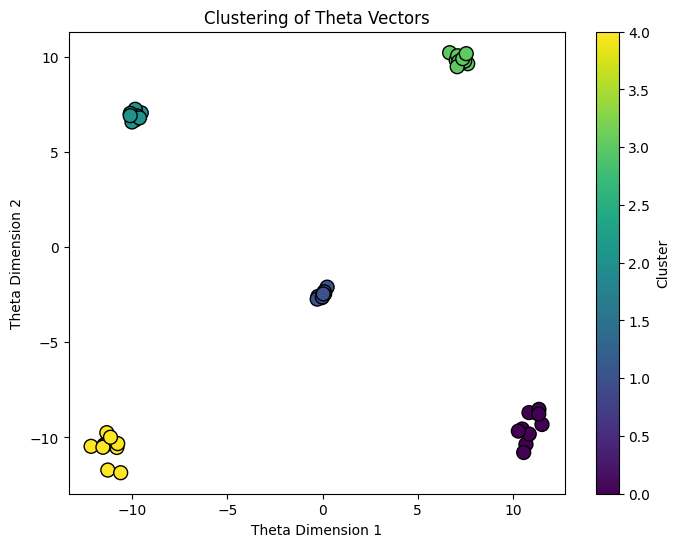

In [4]:
# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(theta_values[:, 0], theta_values[:, 1], c=cluster_labels, cmap='viridis', s=100, edgecolors='k')
plt.xlabel("Theta Dimension 1")
plt.ylabel("Theta Dimension 2")
plt.title("Clustering of Theta Vectors")
plt.colorbar(label="Cluster")
plt.show()


Preuve que self.theta permet de distinguer les groupes de cibles
L’application du clustering K-Means sur les vecteurs self.theta a produit 5 clusters distincts, avec les mêmes labels répartis périodiquement tous les 5 indices

## Consigne 3

### **Rôle de `self.theta`, du bruit (`noise`) et de la division par 1000**  

#### **`self.theta` :**  
- C’est un **vecteur 2D appris** pour chaque groupe de **1000 échantillons**.  
- Il représente la **"signature" du groupe**, capturant les caractéristiques de la fonction \( f_k \) utilisée pour générer les cibles de ce groupe.  
- Pendant l'entraînement, le modèle **ajuste ces vecteurs** afin de mieux distinguer les différents groupes.  

---

#### **Bruit (`noise`) :**  
- Du bruit aléatoire est ajouté aux vecteurs `self.theta` lors de l'entraînement.  
- Cela permet **d’améliorer la généralisation** en introduisant de **petites variations aléatoires**.  
- Sans ce bruit, le modèle pourrait **trop s’adapter aux données d'entraînement** et ne pas bien généraliser aux nouveaux échantillons (**overfitting**).  

---

#### **Division par 1000 :**  
- Le dataset est divisé en **groupes de 1000 échantillons**, chaque groupe étant associé à une fonction \( f_k \) spécifique.  
- La formule `indices // 1000` permet d'assigner **le bon vecteur `theta`** à chaque échantillon en fonction de son groupe.  

**Exemple :**  
- Échantillons **0 à 999** → **groupe 0** → utilise `theta[0]`.  
- Échantillons **1000 à 1999** → **groupe 1** → utilise `theta[1]`.  
- Et ainsi de suite.  

**Conclusion :**  
L’association de `self.theta`, du **bruit** et de la **division par 1000** permet au modèle d’apprendre **une représentation latente des groupes cachés**, ce qui lui permet de bien regrouper les échantillons selon leur fonction génératrice. 🚀  

